In [ ]:
!pip install transformers
!pip install evaluate
!pip install sentencepiece

In [2]:
import pandas as pd
import torch
from tqdm import tqdm
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, RandomSampler
from transformers import T5Model, T5ForConditionalGeneration, T5TokenizerFast
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install rouge-score
from rouge_score import rouge_scorer

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=45255d0856b1d94bc15eb443a2a8d01281cd18e79eb8d1198d91a09a07a9bace
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import custom module

In [4]:
%cd /content/drive/MyDrive/ITMO/T5QA/src
%ls

/content/drive/MyDrive/ITMO/T5QA/src
medqadataset.py  __pycache__/  trainer.py


In [39]:
from medqadataset import MedQADataset
import trainer

In [46]:
# For debugging
import importlib
importlib.reload(trainer)

<module 'trainer' from '/content/drive/MyDrive/ITMO/T5QA/src/trainer.py'>

In [6]:
#MODEL_NAME = "cointegrated/rut5-base"    # pre-trained model (first iteration)
MODEL_NAME = "/content/drive/MyDrive/ITMO/T5QA/checkpoints/best_model/MedQAModel_aug_ans"
TOKENIZER = T5TokenizerFast.from_pretrained(MODEL_NAME, local_files_only=True)
#TOKENIZER = T5TokenizerFast.from_pretrained(MODEL_NAME)
# Set up the T5 model
MODEL = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)
# Set up the optimizer
OPTIMIZER = Adam(MODEL.parameters(), lr=0.0001)
Q_LEN = 512    # Question Length
T_LEN = 128    # Target Length
BATCH_SIZE = 4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
DEVICE

'cpu'

### Read Data

In [7]:
PATH = '/content/drive/MyDrive/ITMO/T5QA'

data = pd.read_csv(PATH + '/data/MedQuAD_answers_augmented_concat.csv', index_col=0)
data.index = [i for i in range(len(data))]

data

,question,context,answer
0,что такое кератодермия с пушистыми волосами?,кератодермия с пушистыми волосами представляе...,кератодермия с пушистыми волосами представляет...
1,сколько людей с шерстяными волосами страдают к...,кератодермия с пушистыми волосами представляе...,кератодермия с пушистыми волосами встречается ...
2,"каковы генетические изменения, связанные с кер...",кератодермия с пушистыми волосами представляе...,"мутации в генах jup, dsp, dsc2 и kank2 вызываю..."
3,передается ли кератодермия с пушистыми волосами?,кератодермия с пушистыми волосами представляе...,большинство случаев кератодермии с курчавыми в...
4,что такое синдром кноблоха?,"синдром кноблоха редкое заболевание, характер...","синдром кноблоха редкое заболевание, характери..."
...,...,...,...
1317,какие генетические изменения связаны с атаксие...,атаксия фридрейха это генетическое заболевани...,мутации в гене fxn вызывают атаксию фридрейха...
1318,что такое являются редкими заболеваниями?,"редкое заболевание это заболевание, которым с...",более 25 миллионов американцев имеют один. сущ...
1319,что такое являются гранулематоз с полиангиитом?,"гранулематоз с полиангиитом гпа, ранее извест...",гранулематоз вегенера редкое заболевание. вос...
1320,что такое мальформация киари?,мальформации киари мк представляют собой стру...,км это структурные дефекты мозжечка. часть че...


### Example

In [11]:
sample = data.iloc[2]
encoding = TOKENIZER(
    sample["question"],
    sample["context"],
    max_length=512,
    padding="max_length",
    truncation="only_second",
    return_attention_mask=True,
    add_special_tokens=True,
    return_tensors='pt'
)

answer_encoding = TOKENIZER(
    sample["answer"],
    max_length=128,
    padding="max_length",
    truncation=True,
    return_attention_mask=True,
    add_special_tokens=True,
    return_tensors="pt"
)

labels = answer_encoding["input_ids"]

output = MODEL(
    input_ids=encoding["input_ids"],
    attention_mask=encoding["attention_mask"],
    labels=labels
)

In [12]:
output.loss

tensor(0.6124, grad_fn=<NllLossBackward0>)

In [13]:
sample_q = data.iloc[2]["question"]
sample_a = data.iloc[2]["answer"]

sample_encoding = TOKENIZER(sample_q, sample_a)

In [14]:
sample_encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [15]:
preds = [
    TOKENIZER.decode(input_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    for input_id in sample_encoding["input_ids"]
]

In [16]:
" ".join(preds)

'как овы гене тические измен ения , связ анные с  кера то дерм ией с пуш исты ми волос ами ?  му тации в  ген ах ju p , d s p , d s c 2  и kan k 2 выз ывают  кера то дерм ию с шер стис тыми тип ами волос от  i до  i v со ответственно .  ген ы ju p , d s p  и d s c 2 предостав ляют инструкци и по созда нию компонент ов  специализ ированных клет очных структур , называ емых дес м осом ами . дес м осом ы  расположен ы в  м ембран е , окруж ающей определен ные клет ки , в том  числе клет ки кож и  и  сердеч ной мыш цы . дес м осом ы помог ают при креп лять клет ки друг к друг у , что обеспеч ивает про чность  и стабил ьность ткан ей .  они так же игра ют  роль в  передач е сигнал ов между клет ками . му тации  ген ов ju p , d s p или d s c 2 измен яют структур у  и наруш ают функци ю дес м осом .  аном альные или от сутств ующие дес м осом ы пре пят ствуют эффектив ному с лип анию клет ок друг с друг ом , что ,  вероятно , дела ет волос ы , кож у  и  сердеч ную мыш цу  более  х руп кими . 

### Dataloaders

In [17]:
train_data, test_data = train_test_split(data, test_size=0.02, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

print(f"Train shape: {train_data.shape}")
print(f"Validation shape: {val_data.shape}")
print(f"Test shape: {test_data.shape}")

train_sampler = RandomSampler(train_data.index)
val_sampler = RandomSampler(val_data.index)

qa_dataset = MedQADataset(TOKENIZER, data, Q_LEN, T_LEN)

train_loader = DataLoader(qa_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
val_loader = DataLoader(qa_dataset, batch_size=BATCH_SIZE, sampler=val_sampler)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(OPTIMIZER, patience=5, verbose=True)

Train shape: (1036, 3)
Validation shape: (259, 3)
Test shape: (27, 3)


### Train and validation loop

In [47]:
N_EPOCHS = 100
STATE_DICT_PATH = '/content/drive/MyDrive/ITMO/T5QA/checkpoints/best_model/MedQAModel_aug_ans'

trainer_module = trainer.Trainer(
    MODEL,
    N_EPOCHS,
    STATE_DICT_PATH,
    train_loader,
    val_loader,
    OPTIMIZER,
    DEVICE,
    TOKENIZER,
    Q_LEN,
    T_LEN,
    scheduler
)

In [ ]:
trainer_module.fit()

Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 0		Train loss: 5.533194344936651		Validation loss: 1.7880845757631154


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.90it/s]


Epoch: 1		Train loss: 2.8098868150048273		Validation loss: 1.5522852833454426


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.92it/s]


Epoch: 2		Train loss: 2.4295752996643536		Validation loss: 1.4317196969802564


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 3		Train loss: 2.1846930704521856		Validation loss: 1.3066269819553082


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.89it/s]


Epoch: 4		Train loss: 2.0286568941757026		Validation loss: 1.240663025700129


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.92it/s]


Epoch: 5		Train loss: 1.8956662257665833		Validation loss: 1.1661616444587708


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.92it/s]


Epoch: 6		Train loss: 1.7891119568964688		Validation loss: 1.1121516053493206


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 7		Train loss: 1.6705850832250588		Validation loss: 1.0602090074465824


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.88it/s]


Epoch: 8		Train loss: 1.5826308980411545		Validation loss: 1.013795066338319


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.89it/s]


Epoch: 9		Train loss: 1.5211764481997399		Validation loss: 0.9698750897095754


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.89it/s]


Epoch: 10		Train loss: 1.4313035201151858		Validation loss: 0.9075209851448353


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.88it/s]


Epoch: 11		Train loss: 1.3791978564041463		Validation loss: 0.8562765375925945


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.90it/s]


Epoch: 12		Train loss: 1.3138990495425853		Validation loss: 0.8253763503753222


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 13		Train loss: 1.2925764567373341		Validation loss: 0.7870753774276147


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.90it/s]


Epoch: 14		Train loss: 1.5271181089077217		Validation loss: 0.8335378690407826


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.88it/s]


Epoch: 15		Train loss: 1.311543085515269		Validation loss: 0.7783039725743808


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.89it/s]


Epoch: 16		Train loss: 1.2094165246689181		Validation loss: 0.7150742633984639


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.88it/s]


Epoch: 17		Train loss: 1.1418361326672395		Validation loss: 0.6896031271952849


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.90it/s]


Epoch: 18		Train loss: 1.091032810077704		Validation loss: 0.662782393854398


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.89it/s]


Epoch: 19		Train loss: 1.1854206953039501		Validation loss: 0.7399634214547964


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.90it/s]


Epoch: 20		Train loss: 1.2792379005765362		Validation loss: 0.6932036363161527


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.92it/s]


Epoch: 21		Train loss: 1.097633566520389		Validation loss: 0.6573705226182938


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.90it/s]


Epoch: 22		Train loss: 1.0186334453724526		Validation loss: 0.5907776756928518


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.90it/s]


Epoch: 23		Train loss: 0.9716387887028654		Validation loss: 0.5625163981547723


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.92it/s]


Epoch: 24		Train loss: 0.949922863753606		Validation loss: 0.54474958679997


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.90it/s]


Epoch: 25		Train loss: 0.8888228277902346		Validation loss: 0.5001292342176804


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 26		Train loss: 0.8458639578929739		Validation loss: 0.48045408932062295


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.92it/s]


Epoch: 27		Train loss: 0.8183324602234778		Validation loss: 0.4426045179367065


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.92it/s]


Epoch: 28		Train loss: 0.882564946663886		Validation loss: 0.4571001905088241


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.92it/s]


Epoch: 29		Train loss: 0.8076085666316817		Validation loss: 0.4371855535186254


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.90it/s]


Epoch: 30		Train loss: 0.7541484313812035		Validation loss: 0.4012260988354683


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.88it/s]


Epoch: 31		Train loss: 0.721540511114717		Validation loss: 0.3752392223248115


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.90it/s]


Epoch: 32		Train loss: 0.6811679216770592		Validation loss: 0.34251991567703394


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.90it/s]


Epoch: 33		Train loss: 0.6524758074562061		Validation loss: 0.3276267636853915


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.88it/s]


Epoch: 34		Train loss: 0.6254544528524848		Validation loss: 0.30525856350476926


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.90it/s]


Epoch: 35		Train loss: 0.5881187507314571		Validation loss: 0.278160396275612


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.89it/s]


Epoch: 36		Train loss: 0.5688662903534399		Validation loss: 0.2618276025240238


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.88it/s]


Epoch: 37		Train loss: 0.5383093671218769		Validation loss: 0.2331371009349823


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.90it/s]


Epoch: 38		Train loss: 0.5276538532040294		Validation loss: 0.22740508111623617


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.89it/s]


Epoch: 39		Train loss: 0.503213867228694		Validation loss: 0.2063559589191125


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.89it/s]


Epoch: 40		Train loss: 0.4718963612863456		Validation loss: 0.19017304755174197


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.88it/s]


Epoch: 41		Train loss: 0.4486031706613924		Validation loss: 0.17413434890600352


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.92it/s]


Epoch: 42		Train loss: 0.42898865049870316		Validation loss: 0.1533683304889844


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.92it/s]


Epoch: 43		Train loss: 0.4024083357750219		Validation loss: 0.14220977975771978


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.88it/s]


Epoch: 44		Train loss: 0.38013721044574467		Validation loss: 0.11667809206992388


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 45		Train loss: 0.3621865954235714		Validation loss: 0.11511720436123701


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.90it/s]


Epoch: 46		Train loss: 0.3521137357218385		Validation loss: 0.10350290488165159


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.87it/s]


Epoch: 47		Train loss: 0.3299516602257504		Validation loss: 0.0926543279336049


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.90it/s]


Epoch: 48		Train loss: 0.30710394512214717		Validation loss: 0.0797640442991486


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 49		Train loss: 0.28680242075940815		Validation loss: 0.0693761296570301


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.90it/s]


Epoch: 50		Train loss: 0.26714196917690824		Validation loss: 0.06074839612612357


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.92it/s]


Epoch: 51		Train loss: 0.2516255164986412		Validation loss: 0.05858796962465231


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.90it/s]


Epoch: 52		Train loss: 0.23769652237935876		Validation loss: 0.04981295873339359


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 53		Train loss: 0.22238811157269828		Validation loss: 0.04757945780785611


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch: 54		Train loss: 0.21401808561189065		Validation loss: 0.04093350226847598


Validation batches: 100%|██████████| 65/65 [00:16<00:00,  3.92it/s]


Epoch: 55		Train loss: 0.19771527011364584		Validation loss: 0.0388276509116762


Training batches:  41%|████      | 105/259 [01:17<01:51,  1.38it/s]

### Evaluate the results

In [48]:
test_sample = test_data.iloc[0]
test_context = f"Контекст: {test_sample['context']}"
test_question = f"Вопрос: {test_sample['question']}"
test_answer = f"{test_sample['answer']}"

pred = trainer_module.predict_answer(
    test_context,
    test_question,
    test_answer,
    print_text=True
)

pred

Контекст: перелом ребра это трещина или перелом одной или нескольких реберных костей. ребра это кости грудной клетки, которые охватывают верхнюю часть тела. они соединяют грудную кость с позвоночником. риск перелома ребер после травмы увеличивается с возрастом. подробнее о травме перелом ребер может быть очень болезненным, потому что ребра двигаются, когда вы дышите, кашляете и двигаете верхней частью тела. ребра в середине грудной клетки ломаются чаще всего. переломы ребер часто возникают при других травмах грудной клетки и органов. поэтому ваши медицинские работники также проверят, есть ли у вас какиелибо другие травмы. чего ожидать? заживление займет не менее 6 недель. если вы повредили другие органы тела, вам, возможно, придется остаться в больнице. в противном случае вы можете лечиться дома. большинству людей со сломанными ребрами хирургическое вмешательство не требуется. в отделении неотложной помощи вам, возможно, дали сильнодействующее лекарство например, блокаду нерва или нарк

{'Reference Answer: ': 'перелом ребра это трещина или перелом одной или нескольких реберных костей. ребра это круглые плоские кости в груди, которые охватывают верхнюю часть тела. они соединяют вашу грудину с позвоночником.',
 'Predicted Answer: ': 'Ответ: перелом ребра это трещина или перелом одной или нескольких',
 'BLEU Score: ': {'google_bleu': 0.23809523809523808},
 'RougeL (precision): ': 0}

In [20]:
# Calculate metrics on test
bleu_avg, rouge_avg = trainer_module.calc_avg_metrics(test_data)
print("Test:")
print("BLEU:", bleu_avg)
print("RougeL:", rouge_avg)

Test:
BLEU: 0.2098802666579037
RougeL: 0.037037037037037035


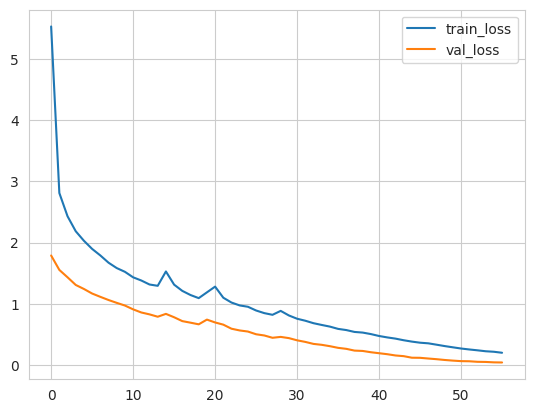

In [25]:
loss_filepath = "/content/drive/MyDrive/ITMO/T5QA/data/t5_MedQA_ans_aug_loss_56.csv"
# Plot loss
trainer_module.plot_loss(filepath=loss_filepath)

### Inference

In [31]:
test_sample = test_data.iloc[3]
test_context = f"Контекст: {test_sample['context']}"
test_question = f"Вопрос: {test_sample['question']}"

pred = trainer_module.predict_answer(
   test_context,
   test_question
)

print(test_question)
print(test_context)
print(pred)

Вопрос:  как диагностировать выпотной средний отит? также называется: оме; секреторный средний отит; серозный средний отит; тихий средний отит; тихая инфекция уха; клеевое ухо
Контекст: средний отит с выпотом соме представляет собой густую или липкую жидкость за барабанной перепонкой в ​​среднем ухе. это происходит без ушной инфекции. причины евстахиева труба соединяет внутреннюю часть уха с задней частью горла. эта трубка помогает отводить жидкость, предотвращая ее скопление в ухе. жидкость вытекает из трубки и проглатывается. соме и ушные инфекции связаны двумя способами: после лечения большинства ушных инфекций жидкость выпот остается в среднем ухе в течение нескольких дней или недель. частично заблокирован, в среднем ухе скапливается жидкость. бактерии внутри уха попадают в ловушку и начинают расти. это может привести к ушной инфекции. следующие факторы могут вызвать отек слизистой оболочки евстахиевой трубы, что приводит к увеличению количества жидкости в среднем ухе: аллергия раз

In [28]:
test_sample = test_data.iloc[15]
test_context = f"Контекст: {test_sample['context']}"
test_question = f"Вопрос: {test_sample['question']}"

pred = trainer_module.predict_answer(
   test_context,
   test_question
)

print(test_question)
print(test_context)
print(pred)

Вопрос:  наследуется ли дефицит фактора комплемента i? также называется: дефицит инактиватора c3; дефицит инактиватора компонента 3 комплемента
Контекст:  дефицит фактора комплемента i это заболевание, которое влияет на иммунную систему. люди с этим заболеванием склонны к рецидивирующим инфекциям, включая инфекции верхних дыхательных путей, ушей, кожи и мочевыводящих путей. они также могут заразиться более серьезными инфекциями, такими как пневмония, менингит и сепсис, которые могут быть опасными для жизни. у некоторых людей с дефицитом фактора комплемента i наблюдается заболевание почек, называемое гломерулонефритом, с изолированными отложениями c3. дефицит фактора комплемента i также может быть связан с аутоиммунными заболеваниями, такими как ревматоидный артрит или системная красная волчанка скв. аутоиммунные заболевания возникают, когда иммунная система дает сбой и атакует ткани и органы организма. частота дефицит фактора комплемента i является редким заболеванием; его точная распр

In [32]:
test_sample = test_data.iloc[22]
test_context = f"Контекст: {test_sample['context']}"
test_question = f"Вопрос: {test_sample['question']}"

pred = trainer_module.predict_answer(
   test_context,
   test_question
)

print(test_question)
print(test_context)
print(pred)

Вопрос:  каковы методы лечения зуда джока? также называется: грибковая инфекция пах; инфекция грибковая пах; зуд в паху; стригущий лишай пах; tinea cruris; tinea паха
Контекст: зуд спортсмена это инфекция паховой области, вызванная грибком. медицинский термин tinea cruris или стригущий лишай в паху. причины: зуд спортсмена возникает, когда определенный тип грибка растет и распространяется в области паха. зуд спортсмена возникает в основном у взрослых мужчин и мальчиковподростков. у некоторых людей, страдающих этой инфекцией, также имеется микоз стопы или другой вид стригущего лишая. грибок, вызывающий зуд спортсмена, процветает в теплых и влажных местах. зуд спортсмена может быть вызван трением одежды и длительной влажностью в области паха, например, изза потоотделения. грибковая инфекция стоп может распространиться на паховую область при натягивании брюк, если пояс загрязнен грибком с ног. спортивный зуд может передаваться от одного человека к другому при прямом контакте кожа к коже и

In [38]:
test_sample = test_data.iloc[14]
test_context = f"Контекст: {test_sample['context']}"
test_question = f"Вопрос: {test_sample['question']}"

pred = trainer_module.predict_answer(
   test_context,
   test_question
)

print(test_question)
print(test_context)
print(pred)

Вопрос:  нужно ли мне обращаться к врачу по поводу проблем с глотанием?
Контекст: затруднение глотания это ощущение, что пища или жидкость застревает в горле или в любой момент перед попаданием пищи в желудок. эту проблему также называют дисфагией. она может быть вызвана расстройством головного мозга или нервов, стрессом или тревогой, а также проблемами, затрагивающими заднюю часть языка, горло и пищевод трубку, ведущую от горла к желудку. ожидаемые дома симптомы проблем с глотанием включают в себя: кашель или удушье во время или после еды булькающие звуки в горле во время или после еды прочищение горла после питья или глотания медленное пережевывание или прием пищи повторный кашель после еды икота после глотания дискомфорт в груди во время или после глотания необъяснимая потеря веса симптомы могут быть легкими или тяжелыми. уход на дому большинству людей с дисфагией следует обратиться к врачу, если симптомы сохраняются или возвращаются. но эти общие советы могут помочь. во время еды с